In [341]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

In [342]:
with open("simu8_data/simu8_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 1000]
# df_test = df_test.loc[df_test.session < 1000]

In [343]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,serial_pos,list,session
0,12,24,Face12,Joe,0,0,0
1,2,29,Face2,Mark,1,0,0
2,6,27,Face6,Dan,2,0,0
3,13,18,Face13,John,3,0,0
4,11,31,Face11,George,4,0,0
...,...,...,...,...,...,...,...
79995,8,30,Face8,Mike,3,0,9999
79996,9,24,Face9,Joe,4,0,9999
79997,7,28,Face7,Paul,5,0,9999
79998,16,23,Face16,Charles,6,0,9999


In [344]:
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session
0,1,Face1,30,6,0,0
1,2,Face2,29,1,0,0
2,6,Face6,27,2,0,0
3,14,Face14,22,7,0,0
4,13,Face13,18,3,0,0
...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999
79996,15,Face15,25,0,0,9999
79997,8,Face8,30,3,0,9999
79998,16,Face16,23,6,0,9999


In [345]:
# load and get face distance
face_distance = np.load('simu8_data/simu8_distance.npy')
def get_distance(df_tmp):
    faces = np.unique(df_tmp.test_itemno)
    face_dist = {}
    for face in faces:
        this_dist = []
        for other_face in faces:
            if face != other_face:
                this_dist.append(face_distance[face-1,other_face-1])
        this_dist = np.array(this_dist)
        face_dist[face] = this_dist
    y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
    return y

# get number of neighbours by distance
df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
distance_threshs = [2.8, 3.0, 3.2]
for thresh in distance_threshs:
    df_test['neighbour_'+str(thresh)] = df_test.apply(lambda x: sum(x['distance'] < thresh), axis=1)
    df_test['neighbour_group_'+str(thresh)] = df_test.apply(lambda x: 6 if x['neighbour_'+str(thresh)] == 7 else x['neighbour_'+str(thresh)], axis=1)
df_test

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_11680/2914563358.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']


,test_itemno,test_item,correct_ans,study_pos,list,session,distance,neighbour_2.8,neighbour_group_2.8,neighbour_3.0,neighbour_group_3.0,neighbour_3.2,neighbour_group_3.2
0,1,Face1,30,6,0,0,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",3,3,5,5,5,5
1,2,Face2,29,1,0,0,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",4,4,5,5,5,5
2,6,Face6,27,2,0,0,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",4,4,5,5,6,6
3,14,Face14,22,7,0,0,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",4,4,6,6,6,6
4,13,Face13,18,3,0,0,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",5,5,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999,"[2.1647, 2.202, 2.8935, 2.2233, 3.5825, 3.9391...",3,3,4,4,4,4
79996,15,Face15,25,0,0,9999,"[3.9391, 3.1458, 3.3766, 2.4733, 3.4689, 1.838...",3,3,3,3,4,4
79997,8,Face8,30,3,0,9999,"[2.2233, 2.4245, 3.194, 3.508, 3.4755, 3.4689,...",2,2,2,2,3,3
79998,16,Face16,23,6,0,9999,"[4.0651, 3.4535, 3.3654, 2.7967, 3.2039, 2.360...",3,3,3,3,3,3


In [346]:
df_test.groupby('neighbour_group_3.0').test_itemno.count()

neighbour_group_3.0
0      229
1     2560
2     9942
3    20758
4    24779
5    16382
6     5350
Name: test_itemno, dtype: int64

In [347]:
# load semantic matrix
s_mat = np.load('simu8_data/simu8_smat.npy')

### Run CMR-IA

In [348]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.6, # 0.5
    beta_rec = 0.5,
    beta_cue = 0.8, # 0.7, overall accuracy important
    beta_distract = 0.1,  # 0
    gamma_fc = 0.6, # 0.4
    gamma_cf = 0.6, # 0.6
    s_fc = 0.5, # 0.4, s_cf has no effect
    c_thresh = 0.45, # 0.01
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.04,
    eta = 0.01,
    alpha = 0.5,
    omega = 2,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 16, # must be 16
    d_ass = 0,
    No_recall = np.arange(0,8),
    use_new_context = True,
)
params

{'beta_enc': 0.6,
 'beta_rec': 0.5,
 'beta_cue': 0.8,
 'beta_rec_post': 0.5,
 'beta_distract': 0.1,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0,
 's_fc': 0.5,
 'kappa': 0.08,
 'eta': 0.01,
 'omega': 2,
 'alpha': 0.5,
 'c_thresh': 0.45,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.01,
 'd_ass': 0,
 'lamb': 0.04,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 16,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.6,
 'gamma_cf': 0.6,
 'use_new_context': True}

In [349]:
# run CMR
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params, df_study, df_test ,s_mat)
df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])
df_simu

CMR2 Time: 25.521203994750977


,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour_2.8,neighbour_group_2.8,neighbour_3.0,neighbour_group_3.0,neighbour_3.2,neighbour_group_3.2
0,0,0,1,19.0,1960.0,0.650892,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",3,3,5,5,5,5
1,0,0,2,29.0,1580.0,0.679351,Face2,29,1,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",4,4,5,5,5,5
2,0,0,6,27.0,2110.0,0.757550,Face6,27,2,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",4,4,5,5,6,6
3,0,0,14,22.0,1610.0,0.762507,Face14,22,7,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",4,4,6,6,6,6
4,0,0,13,18.0,1710.0,0.759384,Face13,18,3,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",5,5,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0,9999,1,20.0,1380.0,0.692822,Face1,20,1,"[2.1647, 2.202, 2.8935, 2.2233, 3.5825, 3.9391...",3,3,4,4,4,4
79996,0,9999,15,25.0,1450.0,0.639795,Face15,25,0,"[3.9391, 3.1458, 3.3766, 2.4733, 3.4689, 1.838...",3,3,3,3,4,4
79997,0,9999,8,18.0,1950.0,0.618477,Face8,30,3,"[2.2233, 2.4245, 3.194, 3.508, 3.4755, 3.4689,...",2,2,2,2,3,3
79998,0,9999,16,23.0,1700.0,0.765383,Face16,23,6,"[4.0651, 3.4535, 3.3654, 2.7967, 3.2039, 2.360...",3,3,3,3,3,3


In [350]:
df_simu.query("s_resp == -2").shape

(380, 16)

In [351]:
df_simu.query("s_resp == -1").shape

(5, 16)

In [352]:
df_simu.to_pickle("simu8_data/simu8_result.pkl")

### Analysis

In [353]:
with open("simu8_data/simu8_result.pkl", 'rb') as inp:
    df_simu = pickle.load(inp)

In [354]:
# get correction
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
print("correct rate: ", sum(df_simu.correct)/len(df_simu.correct))

correct rate:  0.7154


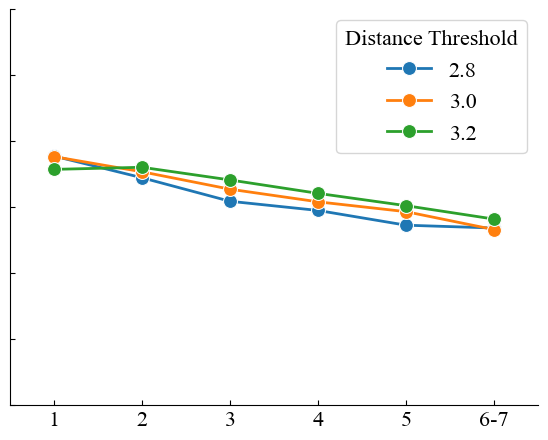

In [355]:
# plt neighborhood effect (as paper)

fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
for thresh in distance_threshs:
    thresh_colname = 'neighbour_group_'+str(thresh)
    df_neighbour_group = df_simu.groupby(thresh_colname).correct.mean().reset_index()
    sns.lineplot(data=df_neighbour_group.loc[df_neighbour_group[thresh_colname] > 0], x=thresh_colname, y='correct', linewidth=2, marker='o', markersize = 10, label=str(thresh))
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
plt.legend(title='Distance Threshold')
ax.set(xlabel=None, ylabel=None)
plt.tick_params(labelleft=False)

plt.savefig('simu8_fig/simu8_correct_neighbourgroup.pdf')
plt.show()

In [356]:
# detect ILI
def get_ILI(df_tmp):
    resp_names = df_tmp['s_resp'].values
    study_names = df_tmp['correct_ans'].values # all correct answers are all studied names
    is_studied = np.isin(resp_names, study_names)
    is_incorrect = df_tmp['correct'] == False
    is_ILI = is_studied & is_incorrect
    return is_ILI

df_simu['ILI'] = df_simu.groupby("session").apply(get_ILI).to_frame(name='ILI').reset_index()['ILI'].to_list()

df_ILI = df_simu.loc[df_simu.ILI == True,:].copy()
df_ILI

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_11680/4130920240.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_simu['ILI'] = df_simu.groupby("session").apply(get_ILI).to_frame(name='ILI').reset_index()['ILI'].to_list()


,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour_2.8,neighbour_group_2.8,neighbour_3.0,neighbour_group_3.0,neighbour_3.2,neighbour_group_3.2,correct,ILI
0,0,0,1,19.0,1960.0,0.650892,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",3,3,5,5,5,5,False,True
9,0,1,11,24.0,1540.0,0.633077,Face11,30,3,"[2.1194, 3.3819, 2.8217, 3.6998, 3.4185, 3.256...",2,2,3,3,3,3,False,True
11,0,1,14,30.0,2360.0,0.603126,Face14,24,2,"[3.1605, 3.0111, 2.4855, 3.7246, 2.1607, 2.394...",3,3,3,3,5,5,False,True
16,0,2,15,21.0,1900.0,0.563379,Face15,29,0,"[3.1458, 2.6255, 1.8388, 2.4593, 3.0899, 3.006...",4,4,4,4,7,6,False,True
24,0,3,6,32.0,1970.0,0.481593,Face6,19,5,"[3.2587, 3.603, 0.9329, 2.8217, 1.6004, 2.4855...",3,3,4,4,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79987,0,9998,2,21.0,2120.0,0.661538,Face2,22,5,"[2.9597, 1.601, 2.0108, 3.2787, 2.558, 3.8765,...",3,3,4,4,4,4,False,True
79988,0,9998,5,22.0,2880.0,0.651278,Face5,21,4,"[1.601, 3.3872, 0.9329, 3.2177, 3.4034, 3.4192...",2,2,2,2,2,2,False,True
79989,0,9998,15,20.0,1900.0,0.460980,Face15,32,1,"[3.8765, 3.1458, 3.4192, 3.3766, 1.8388, 3.011...",2,2,2,2,4,4,False,True
79992,0,9999,3,30.0,1970.0,0.591576,Face3,18,2,"[2.1647, 3.2587, 2.2956, 2.4245, 3.3268, 3.145...",3,3,3,3,4,4,False,True


In [357]:
# get distance between ILI and correct faces
face_distance = np.load('simu8_data/simu8_distance.npy')
with open("simu8_data/simu8_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 1000]

def get_resp_face(df_tmp):
    sess = np.unique(df_tmp.session).item()
    sess_name_face = df_study.query(f"session == {sess}")[["study_itemno1","study_itemno2"]].set_index("study_itemno2").to_dict()['study_itemno1']
    resp_face = df_tmp.apply(lambda x: sess_name_face[x['s_resp']],axis=1)
    return resp_face

df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()
df_ILI['resp_corr_distance'] = df_ILI.apply(lambda x: face_distance[x['test_itemno']-1,x['resp_face']-1], axis=1)
df_ILI['distance_bin'] = df_ILI.apply(lambda x: str(0.5 * (x['resp_corr_distance'] // 0.5 + 1)) if x['resp_corr_distance'] < 3.5 else ">3.5", axis=1)
df_ILI

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_11680/1513154876.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()


,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,...,neighbour_group_2.8,neighbour_3.0,neighbour_group_3.0,neighbour_3.2,neighbour_group_3.2,correct,ILI,resp_face,resp_corr_distance,distance_bin
0,0,0,1,19.0,1960.0,0.650892,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",...,3,5,5,5,5,False,True,8,2.2233,2.5
9,0,1,11,24.0,1540.0,0.633077,Face11,30,3,"[2.1194, 3.3819, 2.8217, 3.6998, 3.4185, 3.256...",...,2,3,3,3,3,False,True,14,2.3944,2.5
11,0,1,14,30.0,2360.0,0.603126,Face14,24,2,"[3.1605, 3.0111, 2.4855, 3.7246, 2.1607, 2.394...",...,3,3,3,5,5,False,True,11,2.3944,2.5
16,0,2,15,21.0,1900.0,0.563379,Face15,29,0,"[3.1458, 2.6255, 1.8388, 2.4593, 3.0899, 3.006...",...,4,4,4,7,6,False,True,9,1.8388,2.0
24,0,3,6,32.0,1970.0,0.481593,Face6,19,5,"[3.2587, 3.603, 0.9329, 2.8217, 1.6004, 2.4855...",...,3,4,4,4,4,False,True,14,2.4855,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79987,0,9998,2,21.0,2120.0,0.661538,Face2,22,5,"[2.9597, 1.601, 2.0108, 3.2787, 2.558, 3.8765,...",...,3,4,4,4,4,False,True,5,1.6010,2.0
79988,0,9998,5,22.0,2880.0,0.651278,Face5,21,4,"[1.601, 3.3872, 0.9329, 3.2177, 3.4034, 3.4192...",...,2,2,2,2,2,False,True,2,1.6010,2.0
79989,0,9998,15,20.0,1900.0,0.460980,Face15,32,1,"[3.8765, 3.1458, 3.4192, 3.3766, 1.8388, 3.011...",...,2,2,2,4,4,False,True,9,1.8388,2.0
79992,0,9999,3,30.0,1970.0,0.591576,Face3,18,2,"[2.1647, 3.2587, 2.2956, 2.4245, 3.3268, 3.145...",...,3,3,3,4,4,False,True,8,2.4245,2.5


In [358]:
# # count probability of ILI from all distance (df_ILI)
# distance_cnt = {}
# for lst in df_ILI.distance:
#     for d in lst:
#         d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
#         if d_group in distance_cnt:
#             distance_cnt[d_group] += 1
#         else:
#             distance_cnt[d_group] = 1

In [359]:
# count probability of ILI from all distance (df_test)
distance_cnt = {}
for lst in df_test.distance:
    for d in lst:
        d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
        if d_group in distance_cnt:
            distance_cnt[d_group] += 1
        else:
            distance_cnt[d_group] = 1

In [360]:
df_ILI_distance = df_ILI.groupby("distance_bin")['test_itemno'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_distance['ILI_poss'] = df_ILI_distance.apply(lambda x: distance_cnt[x['distance_bin']], axis=1)
df_ILI_distance['ILI_prob'] = df_ILI_distance['ILI_cnt'] / df_ILI_distance['ILI_poss']
df_ILI_distance

,distance_bin,ILI_cnt,ILI_poss,ILI_prob
0,1.0,823,9458,0.087016
1,1.5,2363,28004,0.084381
2,2.0,2061,27722,0.074345
3,2.5,5801,102806,0.056427
4,3.0,5135,130298,0.039410
5,3.5,4397,163876,0.026831
6,>3.5,1803,97836,0.018429


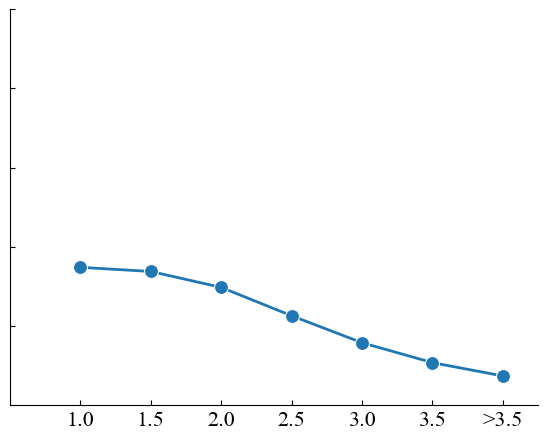

In [361]:
# plot ILI by distance bin
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_distance, x='distance_bin', y='ILI_prob', linewidth=2, marker='o', markersize = 10)
plt.ylim([0,0.25])
plt.xlim([-1,6.5])
plt.xlabel('Distance Bins')
plt.ylabel('Probability of ILI')
ax.set(xlabel=None, ylabel=None)
plt.tick_params(labelleft=False)

plt.savefig('simu8_fig/simu8_ILI_distance.pdf')
plt.show()

### Other Analysis

In [362]:
df_simu['neighbour'] = df_simu['neighbour_3.0']
df_simu['neighbour_group'] = df_simu['neighbour_group_3.0']
df_neighbour_group = df_simu.groupby("neighbour_group").correct.mean().reset_index()
df_neighbour_group

,neighbour_group,correct
0,0,0.847162
1,1,0.776563
2,2,0.753571
3,3,0.727190
4,4,0.708059
5,5,0.693139
6,6,0.665981


In [363]:
df_neighbour = df_simu.groupby("neighbour").correct.mean().reset_index()
df_neighbour

,neighbour,correct
0,0,0.847162
1,1,0.776563
2,2,0.753571
3,3,0.727190
4,4,0.708059
5,5,0.693139
6,6,0.667958
7,7,0.644144


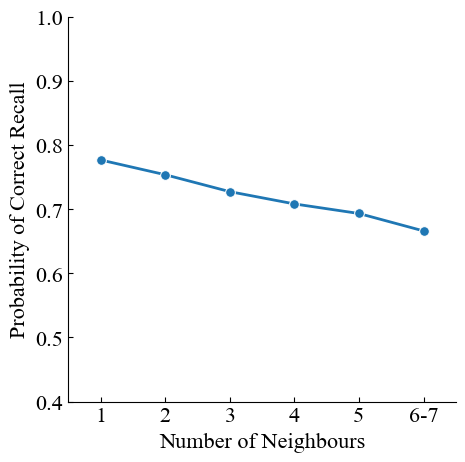

In [364]:
# neigbour group (as paper)
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour_group.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu8_correct_neighbourgroup.pdf')
plt.show()

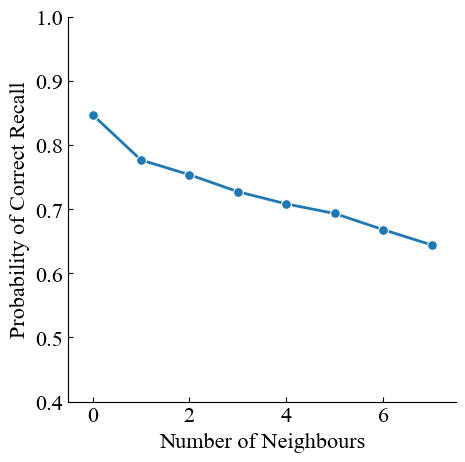

In [365]:
# neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour, x='neighbour', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([-0.5,7.5])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu8_correct_neighbour.pdf')
plt.show()

In [366]:
df_ILI = df_simu.loc[df_simu.ILI == True,:].copy()
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour_2.8,neighbour_group_2.8,neighbour_3.0,neighbour_group_3.0,neighbour_3.2,neighbour_group_3.2,correct,ILI,neighbour,neighbour_group
0,0,0,1,19.0,1960.0,0.650892,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",3,3,5,5,5,5,False,True,5,5
9,0,1,11,24.0,1540.0,0.633077,Face11,30,3,"[2.1194, 3.3819, 2.8217, 3.6998, 3.4185, 3.256...",2,2,3,3,3,3,False,True,3,3
11,0,1,14,30.0,2360.0,0.603126,Face14,24,2,"[3.1605, 3.0111, 2.4855, 3.7246, 2.1607, 2.394...",3,3,3,3,5,5,False,True,3,3
16,0,2,15,21.0,1900.0,0.563379,Face15,29,0,"[3.1458, 2.6255, 1.8388, 2.4593, 3.0899, 3.006...",4,4,4,4,7,6,False,True,4,4
24,0,3,6,32.0,1970.0,0.481593,Face6,19,5,"[3.2587, 3.603, 0.9329, 2.8217, 1.6004, 2.4855...",3,3,4,4,4,4,False,True,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79987,0,9998,2,21.0,2120.0,0.661538,Face2,22,5,"[2.9597, 1.601, 2.0108, 3.2787, 2.558, 3.8765,...",3,3,4,4,4,4,False,True,4,4
79988,0,9998,5,22.0,2880.0,0.651278,Face5,21,4,"[1.601, 3.3872, 0.9329, 3.2177, 3.4034, 3.4192...",2,2,2,2,2,2,False,True,2,2
79989,0,9998,15,20.0,1900.0,0.460980,Face15,32,1,"[3.8765, 3.1458, 3.4192, 3.3766, 1.8388, 3.011...",2,2,2,2,4,4,False,True,2,2
79992,0,9999,3,30.0,1970.0,0.591576,Face3,18,2,"[2.1647, 3.2587, 2.2956, 2.4245, 3.3268, 3.145...",3,3,3,3,4,4,False,True,3,3


In [367]:
df_ILI_neighbour = df_ILI.query("neighbour > 0").groupby("neighbour_group")['test_item'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_neighbour['neighbour_cnt'] = df_simu.groupby("neighbour_group")['test_item'].count()[1:].to_list()
df_ILI_neighbour['ILI_prob'] = df_ILI_neighbour['ILI_cnt'] / df_ILI_neighbour['neighbour_cnt']
df_ILI_neighbour

,neighbour_group,ILI_cnt,neighbour_cnt,ILI_prob
0,1,552,2560,0.215625
1,2,2411,9942,0.242507
2,3,5560,20758,0.267849
3,4,7121,24779,0.287380
4,5,4938,16382,0.301428
5,6,1766,5350,0.330093


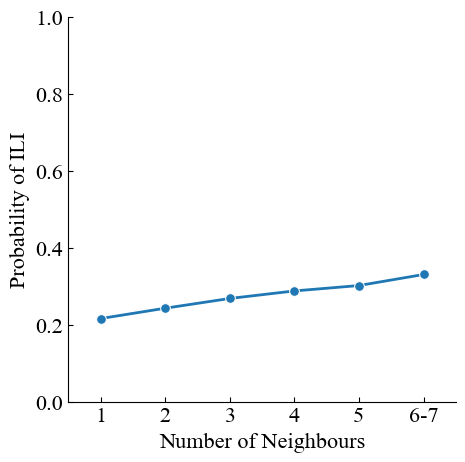

In [368]:
# ILI by neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of ILI')
# plt.savefig('fig/simu8_ILI_neighbourgroup.pdf')
plt.show()